## Installs and Imports

In [ ]:
!pip install transformers
!pip install psycopg2-binary
!pip install torchmetrics

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
import tensorflow 
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.sequence import pad_sequences
import psycopg2
import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plt
from torchmetrics import Accuracy,F1

### Note:
In order to run this notebook, you would need to load the following:
-  'synthetic_testing.parquet" file found in the folder notebooks/datasets
- 'saved_model' folder which is the trained Bert Model

## Load the testing data 

In [ ]:
test_df = pd.read_parquet('/content/synthetic_testing.parquet')
test_df.head()

,tweets,labels
5138,"Tensions in Sweden’s second largest city, Goth...",1
777,"According to preliminary reports, officers Bra...",3
3750,12:54 Report of possible FOUND CHILD at 6XX MT...,0
2051,French police in massive manhunt for rifle-tot...,0
1740,These mass demonstrations were met with violen...,2


## FrankenBert for Predictions

In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification


class FrankenBert:
    """
    Implements BertForSequenceClassification and BertTokenizer
    for binary classification from a saved model
    """

    def __init__(self, path: str):
        """
        If there's a GPU available, tell PyTorch to use the GPU.
        Loads model and tokenizer from saved model directory (path)
        """
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.model.to(self.device)

    def predict(self, text: str):
        """
        Makes a binary classification prediction based on saved model
        """
        inputs = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=280,
            return_tensors='pt',
        ).to(self.device)
        output = self.model(**inputs)
        prediction = output[0].softmax(1)
        tensors = prediction.detach().cpu().numpy()
        result = np.argmax(tensors)
        confidence = tensors[0][result]
        return result

Ensure the path to the model is correct.

In [ ]:
model = FrankenBert('/content/saved_model')

In [ ]:
test_df.shape


(1504, 2)

In [ ]:
test_df.labels.value_counts()

0    535
5    290
1    213
3    179
4    157
2    130
Name: labels, dtype: int64

In [ ]:
# Generating predictions using the model
predictions = []
for tweet in test_df.tweets:
    y_pred = model.predict(tweet)
    predictions.append(y_pred)

In [ ]:
predictions[:10]

[1, 3, 0, 0, 2, 1, 0, 5, 5, 4]

In [ ]:
#Adding the predictions to the testing table
test_df['predictions'] = predictions


In [ ]:
test_df.head()

,tweets,labels,predictions
5138,"Tensions in Sweden’s second largest city, Goth...",1,1
777,"According to preliminary reports, officers Bra...",3,3
3750,12:54 Report of possible FOUND CHILD at 6XX MT...,0,0
2051,French police in massive manhunt for rifle-tot...,0,0
1740,These mass demonstrations were met with violen...,2,2


## **Evaluation Metrics:**
 - F1 Score (using sklear and pytorch metrics libraries)
 - Accuracy (using pytorch metrics libraries)
 - Classification Report
 - Confusion Matrix

In [ ]:
#Preparing our true values and predicted values
y_true = test_df['labels']
y_pred = test_df['predictions']

In [ ]:
#Using sklearn metrics library
f1_score(y_true, y_pred, average='weighted')

0.9678701651341687

In [ ]:
#Using Pytorch metrics library

y_pred = torch.tensor(test_df['predictions'].to_list()) 
y_true = torch.tensor(test_df['labels'].to_list())
f1 = F1(num_classes=6)
print("F1 Score using TorchMetrics::",f1(y_pred, y_true))

F1 Score using TorchMetrics:: tensor(0.9681)


In [ ]:
#Model Accuracy using Pytorch

metric = Accuracy()
y_pred = torch.tensor(test_df['predictions'].to_list()) 
y_true = torch.tensor(test_df['labels'].to_list())

acc = metric(y_pred, y_true)
print("Test Accuracy using TorchMetrics::",acc)

Test Accuracy using TorchMetrics:: tensor(0.9681)


In [ ]:
# Classification Report

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97       535
     class 1       0.94      0.89      0.91       213
     class 2       0.95      0.98      0.97       130
     class 3       0.99      0.98      0.99       179
     class 4       0.99      0.99      0.99       157
     class 5       0.97      0.98      0.98       290

    accuracy                           0.97      1504
   macro avg       0.97      0.97      0.97      1504
weighted avg       0.97      0.97      0.97      1504



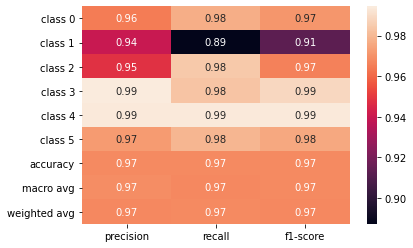

In [ ]:
# Classification Report for HeatMap generation

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

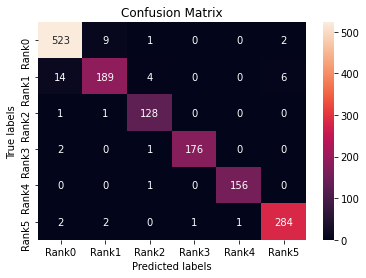

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Rank0', 'Rank1','Rank2','Rank3','Rank4','Rank5']); ax.yaxis.set_ticklabels(['Rank0', 'Rank1','Rank2','Rank3','Rank4','Rank5']);

In [ ]:

data = [['Rank 0', 535,523], 
        ['Rank 1', 213,189], 
        ['Rank 2', 130,128],
        ['Rank 3', 179, 176],
        ['Rank 4', 157,156],
        ['Rank 5',290,284]]

accuracy_table = pd.DataFrame(data=data,columns=['Rank','Testcases','True Positives'])


## Conclusions:

Our model is classifying tweets very well with an accuracy of 96.8%. The data below is proof of this.

In [ ]:
accuracy_table

,Rank,Testcases,True Positives
0,Rank 0,535,523
1,Rank 1,213,189
2,Rank 2,130,128
3,Rank 3,179,176
4,Rank 4,157,156
5,Rank 5,290,284
